In [1]:
from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


Connecting colab to google drive.
Extracting data to a specific folder.

In [0]:

import zipfile
zip_ref = zipfile.ZipFile("/mydrive/My Drive/Project/preprocessedwith1thresh.zip", 'r')
zip_ref.extractall("/content/data1")
zip_ref.close()

In [0]:
import os
a=os.listdir('/content/data1')

Since initially we don't know the index locations of the classes(0 & 1), we will be distinguishing the images corresponding to class 1 only.

To do this, we will first generate a list of strings which match with the image names we are trying to find out the index locations of.
We then run a loop and if a match is found between the real directory containing images and the list previously created, we will be collecting index locations of the image names corresponding to class 1.

In [0]:
#Step 1
list1=[]
for i in range(0,580):
    if i%3==0:
        list1.append('sample_1_'+str(i)+'.png')

#Step 2        
list2=[]
for i in range(0,len(a)):
      if a[i] in list1:
        list2.append(i)

In [5]:
len(list2)

194

Importing necessary apis

In [6]:
# For controlling Python warnings - https://docs.python.org/3.6/library/warnings.html
import warnings
warnings.filterwarnings("ignore")

# For iterators - https://docs.python.org/3.1/library/itertools.html
import itertools

# For loading and handling data
import numpy as np
import pandas as pd

# For Normalization
from sklearn.preprocessing import MinMaxScaler

# For constructing DNN
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input,Dropout,Dense 
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file

# For visualization
import matplotlib.pyplot as plt

# For evaluating the accuracy
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
%matplotlib inline
import os
from PIL import Image

Using TensorFlow backend.


In [0]:
from numpy import *
path1='/content/data1'
imlist=os.listdir(path1)
num_samples=size(imlist)

In [8]:
num_samples

2904

Converting data into a matrix of vectors.

In [0]:
immatrix=array([array(Image.open('/content/data1' + '/' + im2)).flatten() for im2 in imlist], 'f')

Creating an array of size equal to the row size of the data with initial values 1. We will then use the index locations which we found out earlier to change these label values to either 0 (if index of the new loop does not match with label) or 1 (if index of the new loop matches with the label)

In [0]:
labels=np.ones((num_samples,), dtype=int)

In [0]:
for i in range(0,len(labels)):
  if i in list2:
    labels[i]=1
  else:
    labels[i]=0

In [0]:

df1=pd.DataFrame(immatrix)

Adding class column to the dataframe just created.

In [0]:
defi=labels.tolist()
df1['class']=labels

Class Imbalance

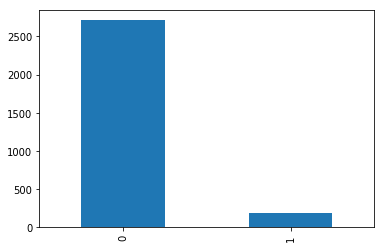

In [0]:
pd.Series(df1.iloc[:,-1]).value_counts().plot.bar()

In [18]:
df1['class'].value_counts()/len(df1)

0    0.933196
1    0.066804
Name: class, dtype: float64

In [0]:
X=np.array(df1.loc[:,df1.columns!='class'])
y=np.array(df1.loc[:,df1.columns=='class']).reshape(-1,1)

Normalizing data. 

In [0]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X=scaler.fit_transform(X)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=2, shuffle=True,stratify=y)

Oversampling using SMOTE to have equal number of class tuples

In [22]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=33)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X_train_new, y_train_new=sm.fit_sample(X_train,y_train)

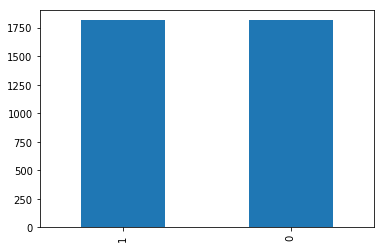

In [0]:
pd.Series(y_train_new).value_counts().plot.bar()

Reshaping data for LSTM

In [0]:
X_train_lst=X_train_new
y_train_lst=y_train_new
X_test_lst=X_test
y_test_lst=y_test.ravel()

In [0]:
X_train_lst=X_train_lst.reshape(X_train_lst.shape[0],X_train_lst.shape[1],1)
X_test_lst=X_test_lst.reshape(X_test_lst.shape[0],X_test_lst.shape[1],1)

In [0]:
from keras.utils import np_utils
y_train_lst=np_utils.to_categorical(y_train_lst,2)
y_test_lst=np_utils.to_categorical(y_test_lst,2)

In [27]:
print(X_train_lst.shape)
print(y_train_lst.shape)
print(X_test_lst.shape)
print(y_test_lst.shape)

(3630, 65536, 1)
(3630, 2)
(959, 65536, 1)
(959, 2)


In [0]:
from keras.layers import LSTM, Flatten,Dense,Dropout, Bidirectional,GlobalMaxPool1D, CuDNNLSTM
from keras.models import Sequential

Building architecture for Bidirectional LSTM.

In [0]:
model=Sequential()
inp = Input(shape=(65536,1))
x=Bidirectional(CuDNNLSTM(10,return_sequences=True))(inp)
x=Dropout(0.25)(x)
x=Flatten()(x)
x =Dense(100, activation="relu")(x)
x=Dropout(0.25)(x)
x=Dense(2,activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Training data

In [30]:
model.fit(X_train_lst,y_train_lst,epochs=3,batch_size=128,verbose=1)

Epoch 1/3
3630/3630 [==============================] - 142s 39ms/step - loss: 2.9380 - acc: 0.7923
Epoch 2/3
3630/3630 [==============================] - 133s 37ms/step - loss: 2.2837 - acc: 0.8485
Epoch 3/3
3630/3630 [==============================] - 133s 37ms/step - loss: 2.8560 - acc: 0.8160


In [0]:
preds=model.predict(X_test_lst[:])

In [0]:
y_test_values=y_test_lst[:,1]
abc=preds[:,1]
abc=np.trunc(abc)

Evaluating model using metric Matthews corrcoef

In [97]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_values,abc)

0.3953005929031948